<a href="https://colab.research.google.com/github/rajadevineni/Income_classification/blob/main/income_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and dataset

In [58]:
!pip install feature_engine

In [59]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from pathlib import Path

pd.pandas.set_option('display.max_columns', None)
%matplotlib inline

## Grid Search import

In [60]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Load dataset

In [61]:
# load dataset
# Dataset is extracted from https://sci2s.ugr.es/keel/dataset.php?cod=192
path = "https://raw.githubusercontent.com/rajadevineni/Income_classification/main/adult.csv"
data = pd.read_csv(path)
print('Number of records in the Dataset: ', len(data))
print('Number of features in the Dataset: ', data.shape[1])
data.head(5)

Number of records in the Dataset:  48842
Number of features in the Dataset:  15


,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


# Inspecting and exploring the data

## Types of variables



In [62]:
# List for categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']

# List for numerical variables
numerical = [var for var in data.columns if data[var].dtype!='O']

# list of variables that contain year information
year_vars = [var for var in numerical if 'Yr' in var or 'Year' in var]

#To identify discrete variables- numerical variables with less than 20 unique values 
# List for discrete variables
discrete = [var for var in numerical if len(data[var].unique()) < 20 and var not in year_vars]

# List for continuous variables
continuous = [var for var in numerical if var not in discrete and var not in [
    'id', 'target'] and var not in year_vars]

print(f'There are {len(categorical)} categorical variables:',categorical)
print(f'There are {len(numerical)} numerical variables:',numerical)
print(f'There are {len(year_vars)} temporal variables:',year_vars)
print(f'There are {len(discrete)} discrete variables:', discrete)
print(f'There are {len(continuous)} continuous variables:', continuous)

There are 9 categorical variables: ['Workclass', 'Education', 'Marital-status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Native-country', 'Class']
There are 6 numerical variables: ['Age', 'Fnlwgt', 'Education-num', 'Capital-gain', 'Capital-loss', 'Hours-per-week']
There are 0 temporal variables: []
There are 1 discrete variables: ['Education-num']
There are 5 continuous variables: ['Age', 'Fnlwgt', 'Capital-gain', 'Capital-loss', 'Hours-per-week']


## Inspecting Data

### Checking for null values in the dataset

* There are null values in Workclass, Occupation and Native-country column

In [63]:
print(data.isna().sum())
#print(data.isnull().mean())

Age                  0
Workclass         2799
Fnlwgt               0
Education            0
Education-num        0
Marital-status       0
Occupation        2809
Relationship         0
Race                 0
Sex                  0
Capital-gain         0
Capital-loss         0
Hours-per-week       0
Native-country     857
Class                0
dtype: int64


### Inspecting the variable values

* Education-num column is the ordinal representation of Education column, therefore we can drop Education-num column

In [64]:
for var in data.columns:
    print(var, data[var].unique()[0:20], '\n')

Age [25 38 28 44 18 34 29 63 24 55 65 36 26 58 48 43 20 37 40 72] 

Workclass ['Private' 'Local-gov' nan 'Self-emp-not-inc' 'Federal-gov' 'State-gov'
 'Self-emp-inc' 'Without-pay' 'Never-worked'] 

Fnlwgt [226802  89814 336951 160323 103497 198693 227026 104626 369667 104996
 184454 212465  82091 299831 279724 346189 444554 128354  60548  85019] 

Education ['11th' 'HS-grad' 'Assoc-acdm' 'Some-college' '10th' 'Prof-school'
 '7th-8th' 'Bachelors' 'Masters' 'Doctorate' '5th-6th' 'Assoc-voc' '9th'
 '12th' '1st-4th' 'Preschool'] 

Education-num [ 7  9 12 10  6 15  4 13 14 16  3 11  5  8  2  1] 

Marital-status ['Never-married' 'Married-civ-spouse' 'Widowed' 'Divorced' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse'] 

Occupation ['Machine-op-inspct' 'Farming-fishing' 'Protective-serv' nan
 'Other-service' 'Prof-specialty' 'Craft-repair' 'Adm-clerical'
 'Exec-managerial' 'Tech-support' 'Sales' 'Priv-house-serv'
 'Transport-moving' 'Handlers-cleaners' 'Armed-Forces'] 

Relationship 

### cardinality (number of different categories)

In [65]:
data.nunique()

Age                  74
Workclass             8
Fnlwgt            28523
Education            16
Education-num        16
Marital-status        7
Occupation           14
Relationship          6
Race                  5
Sex                   2
Capital-gain        123
Capital-loss         99
Hours-per-week       96
Native-country       41
Class                 2
dtype: int64

# Exploratory analysis on the dataset

In [66]:
data.describe()

,Age,Fnlwgt,Education-num,Capital-gain,Capital-loss,Hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


### Creating correlation matrix
* There is no significant correlation between any features

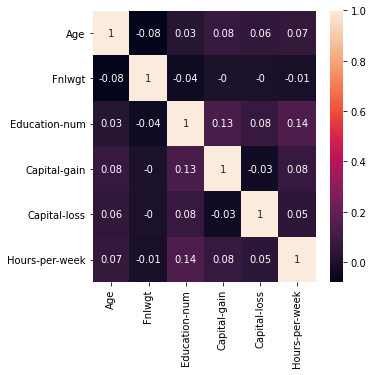

In [67]:
# data.corr(method='pearson', min_periods=1)
# Correlation matrix
correlation_matrix = data.corr().round(2)
figure = plt.figure(figsize=(5, 5))
sns.heatmap(data=correlation_matrix, annot=True)

## Exploring distribution and outliers in the dataset

### Capital gain distribution based on Income class
* This distribution graphs tells us that the outliers based on capital-gains are mostly in >50K class. 
* IF we choose to put a cap based on Capital-Gain then the outliers can be filtered out from Capital-gain>20000 

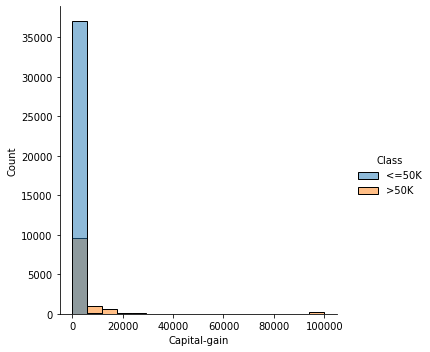

In [68]:
ax = sns.displot(data, x="Capital-gain", hue ='Class')
plt.show()

### Distibution of Fnlwgt based on income Class
* This graph is skewed towards right, we will perform a scalar transformation on this variable in upcoming fature engineering steps

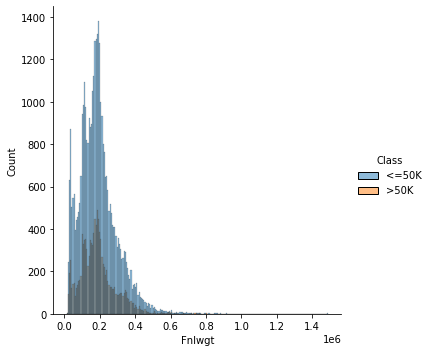

In [69]:
ax = sns.displot(data, x="Fnlwgt", hue ='Class')
plt.show()

### Income vs Age
* There are some out liers bases on the Age with respect to both categories of Income. 
* The records with Age above 70 can be filtered inorder to remove the ourliers

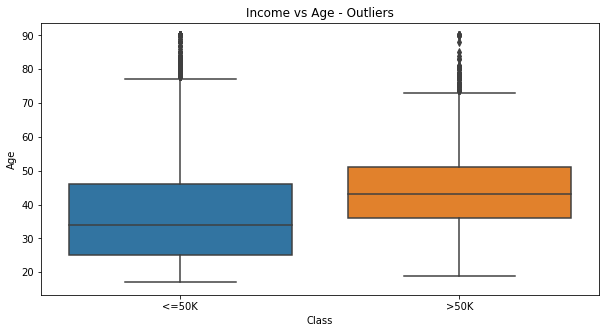

In [70]:
f, ax = plt.subplots(figsize=(10, 5))
ax = sns.boxplot(x="Class", y="Age", data=data)
ax.set_title("Income vs Age - Outliers")
plt.show()

### Frequency distribution of workclass

* We can see that the working class other than "Private" has very lower count  than 5000 observations for respective category.
* We have also seen in the previous section that there are **2799 missing values** in "Workclass" column which is would all combine to form another category. Hence, using *imputation_method='missing'* would be resonable in this case.

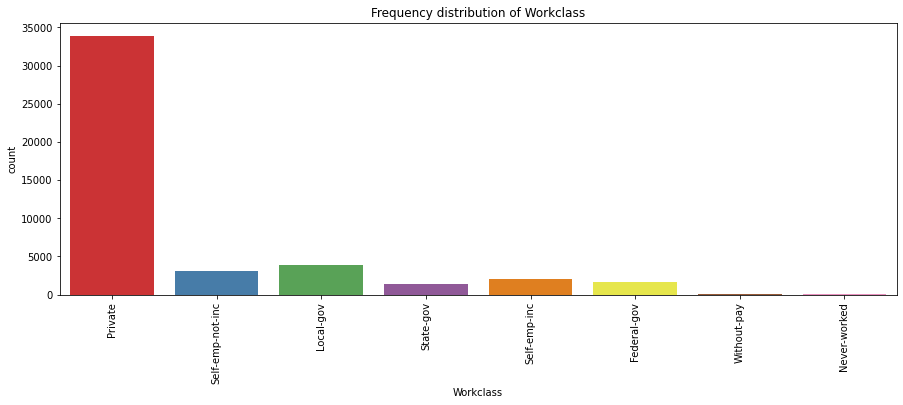

In [71]:
f, ax = plt.subplots(figsize=(15, 5))
ax = sns.countplot(x="Workclass", data=data, palette="Set1")
ax.set_title("Frequency distribution of Workclass")
ax.set_xticklabels(data.Workclass.value_counts().index, rotation=90)
plt.show()

### Frequency distribution of Occupation

* We can see that the Occupation variable has many categories with healthy distributions and only 4 categories such as Tech-support, Armed-Forces and Exec-managerial have less observations. 
* We have also seen in the previous section that there are **2809 missing values** in "Occupation" column. Since there are multiple categories with similar counts,we can create a new missing category using *imputation_method='missing'*

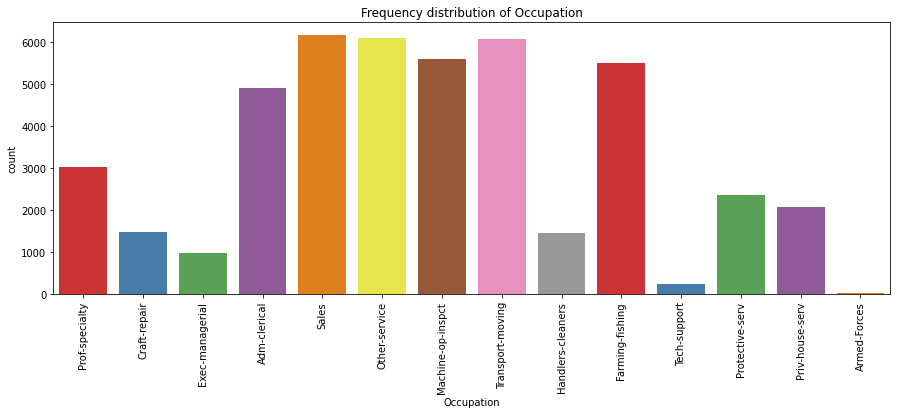

Prof-specialty       6172
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: Occupation, dtype: int64

In [72]:
f, ax = plt.subplots(figsize=(15, 5))
ax = sns.countplot(x="Occupation", data=data, palette="Set1")
ax.set_title("Frequency distribution of Occupation")
ax.set_xticklabels(data.Occupation.value_counts().index, rotation=90)
plt.show()
data['Occupation'].value_counts()

### Frequency distribution of Native-country

* We can see that the Native-country variable has many countries in the variable but ***89.7%*** observations have ***United States*** as the country.
* We have also seen in the previous section that there are **857 missing values** in "Native-country" column. Those missing values can be assigned new missing category using *imputation_method='missing'*. 
* In the later part of pre-processing pipeline, we can groups infrequent countires altogether into one new category called *'Rare'*. 

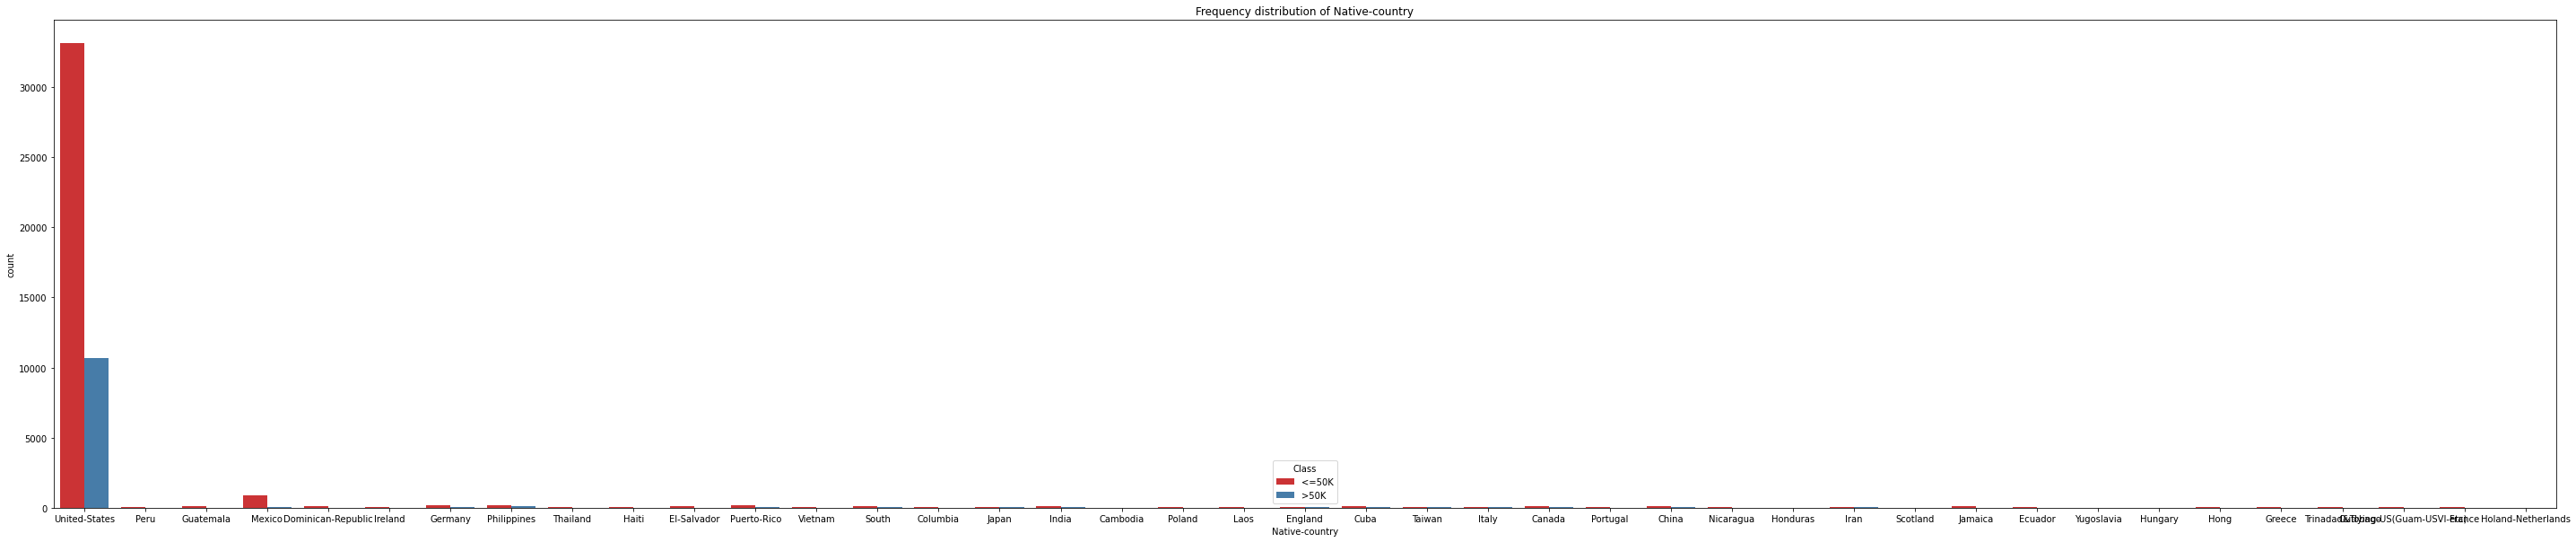

United-States                 43832
Mexico                          951
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Nicaragua                        49
Greece                           49
Peru                             46
Ecuador                     

In [73]:
f, ax = plt.subplots(figsize=(50, 10))
ax = sns.countplot(x="Native-country", data=data, palette="Set1", hue='Class')
ax.set_title("Frequency distribution of Native-country")
plt.show()
data['Native-country'].value_counts()

In [74]:
print('% of observations of United-States:',(data[data['Native-country'] == 'United-States'].shape[0] / data.shape[0])*100)

% of observations of United-States: 89.74243478973015


# Data Transformations and encoding

In [75]:
# from feature-engine
from feature_engine import missing_data_imputers as mdi
# for one hot encoding with feature-engine
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import StandardScaler

## Setting up Features for pre-processing, creating Train and Test datasets

* Since the target variable "Class" is in string we need to convert it to Binary variable for the predictions, Hence we create a new binary variable callled "Target"

In [76]:
# Replacing 
data['Class'] = data['Class'].replace('>50K',1)
data['Class'] = data['Class'].replace('<=50K',0)

# Checking for balance of the dataset
print('% of Positives in the dataset:',(data[data['Class']=='>50K'].shape[0]/data.shape[0])*100)

# Capping the dataset based on Age to remove the outliers
data_capp = data[(data["Age"] <=70)]
print("Removed records:",data.shape[0]-data_capp.shape[0])
print("Updated Records:",data_capp.shape)
print('% of Positives in the filtered dataset:',(data_capp[data_capp['Class']=='>50K'].shape[0]/data_capp.shape[0])*100)

% of Positives in the dataset: 0.0
Removed records: 868
Updated Records: (47974, 15)
% of Positives in the filtered dataset: 0.0


## Function to run the pre processing pipeline

## Subset

In [77]:
# Create subset to fine tune the parameters

data_sub = data.sample(frac=0.6, replace=False, random_state=42)
# separate into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data_sub.drop(['Education','Native-country','Class'], axis=1),  # predictors
    data_sub['Class'],  # target
    test_size=0.1,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility
print("Dataset seperated into, shape of X_train",X_train.shape, "Shape of X_test",X_test.shape,'\n')

Dataset seperated into, shape of X_train (26374, 12) Shape of X_test (2931, 12) 



## Whole dataset

In [78]:
# separate into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Education','Native-country','Class'], axis=1),  # predictors
    data['Class'],  # target
    test_size=0.1,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility
print("Dataset seperated into, shape of X_train",X_train.shape, "Shape of X_test",X_test.shape,'\n')

Dataset seperated into, shape of X_train (43957, 12) Shape of X_test (4885, 12) 



In [79]:
# Function to run the pre processing pipeline
income_pipe = Pipeline([

    # missing data imputation 
    ('imputer_cat_missing',
     mdi.CategoricalVariableImputer(imputation_method='missing',variables=['Workclass','Occupation'])),

    # categorical encoding 
    ('encoder_rare_label',
     RareLabelCategoricalEncoder(tol=0.01,
                                    n_categories=4,
                                    variables=['Race','Relationship','Occupation','Marital-status','Workclass'])),
    ('categorical_encoder',
     OneHotCategoricalEncoder( top_categories=None,
                               variables=['Race','Relationship','Occupation','Marital-status','Workclass','Sex'], # we can select which variables to encode
                               drop_last=True)),
    ('scaler', SklearnTransformerWrapper(transformer=StandardScaler(), variables = ['Fnlwgt','Age','Capital-gain','Capital-loss','Hours-per-week'])),

  ])
income_pipe.fit(X_train, X_test)
# Apply Transformations
X_train=income_pipe.transform(X_train)
X_test=income_pipe.transform(X_test)
print("Data Pre-Processing pipeline completed, shape of X_train",X_train.shape, "Shape of X_test",X_test.shape)

Data Pre-Processing pipeline completed, shape of X_train (43957, 41) Shape of X_test (4885, 41)


# Dummy Classifier (Naive Model)

In [103]:
from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy='most_frequent')
dummy_majority.fit(X_train, y_train)

pred_most_frequent = dummy_majority.predict(X_test)

print("Unique predicted labels: {}".format(np.unique(pred_most_frequent)))
print("Test score: {:.2f}".format(dummy_majority.score(X_test, y_test)))

Unique predicted labels: [0]
Test score: 0.75


In [106]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)
pred_tree = tree.predict(X_test)
print("Test score: {:.2f}".format(tree.score(X_test, y_test)))

Test score: 0.82


In [107]:
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier().fit(X_train, y_train)
pred_dummy = dummy.predict(X_test)
print("dummy score: {:.2f}".format(dummy.score(X_test, y_test)))

logreg = LogisticRegression(C=0.1,max_iter=10000).fit(X_train, y_train)
pred_logreg = logreg.predict(X_test)
print("logreg score: {:.2f}".format(logreg.score(X_test, y_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


dummy score: 0.64
logreg score: 0.84


# Cost Sensitive Classifiers

In [83]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

## Cost Sensitive Logistic regression

In [128]:
logreg = LogisticRegression(solver='lbfgs',max_iter=10000000)
param_grid = {
    
    'class_weight': [{0:10,1:1}, {0:1,1:1}, {0:1,1:10},],
}

#apply grid search
grid_logreg= GridSearchCV(logreg, param_grid, cv=5, n_jobs=2)
grid_logreg.fit(X_train, y_train)

print("Best parameters: {}".format(grid_logreg.best_params_))
print(f'Best Mean Cross Validation Score is {grid_logreg.best_score_}')
print(f'Train score is {grid_logreg.score(X_train,y_train)}')
print(f'Test score is {grid_logreg.score(X_test,y_test)}')

Best parameters: {'class_weight': {0: 1, 1: 1}}
Best Mean Cross Validation Score is 0.8526286008448751
Train score is 0.8530836954296244
Test score is 0.844216990788127


## Cost Sensitive Decison Tree

In [126]:
dtree = DecisionTreeClassifier()
param_grid = {    
    'class_weight': [{0:1,1:1}, {0:1,1:10}],
}

#apply grid search
grid_dtree= GridSearchCV(dtree, param_grid, cv=5, n_jobs=2)
grid_dtree.fit(X_train, y_train)

print("Best parameters: {}".format(grid_dtree.best_params_))
print(f'Best Mean Cross Validation Score is {grid_dtree.best_score_}')
print(f'Train score is {grid_dtree.score(X_train,y_train)}')
print(f'Test score is {grid_dtree.score(X_test,y_test)}')

Best parameters: {'class_weight': {0: 1, 1: 10}}
Best Mean Cross Validation Score is 0.8198693106700137
Train score is 0.9999317514844052
Test score is 0.8176049129989764


## Cost Sensitive SVM

In [127]:
svc = SVC()
param_grid = {
    
    'class_weight': [{0:10,1:1}, {0:1,1:1}, {0:1,1:10}],
}

#apply grid search
grid_svc= GridSearchCV(svc, param_grid, cv=5, n_jobs=2)
grid_svc.fit(X_train, y_train)

print("Best parameters: {}".format(grid_svc.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(grid_svc.best_score_))
print(f'Train score is {grid_svc.score(X_train,y_train)}')
print(f'Test score is {grid_svc.score(X_test,y_test)}')

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best parameters: {'class_weight': {0: 1, 1: 1}}
Best Mean cross-validation score: 0.85
Train score is 0.8547444093090976
Test score is 0.8462640736949847


## Cost Sensitive Random Forest 
- class_weight = 'balanced_subsample' - weight are based on proportions in the bootstrapped sample

In [130]:
from sklearn.ensemble import RandomForestClassifier

In [136]:
rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced_subsample')
param_grid = {    
    'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}],
}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#apply grid search
grid_rfc = GridSearchCV(rfc, param_grid, cv=cv, n_jobs=2)
grid_rfc.fit(X_train, y_train)

print("Best parameters: {}".format(grid_rfc.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(grid_rfc.best_score_))
print(f'Train score is {grid_rfc.score(X_train,y_train)}')
print(f'Test score is {grid_rfc.score(X_test,y_test)}')

Best parameters: {'class_weight': {0: 1, 1: 10}}
Best Mean cross-validation score: 0.86
Train score is 0.9999317514844052
Test score is 0.8575230296827021


## Cost Sensitive Gradient Boosting with XGBoost

In [ ]:
pip install xgboost

In [137]:
xgboost = XGBClassifier()
param_grid = {
    
    'scale_pos_weight': [1, 10, 25, 50, 75, 99, 100, 1000],
}

#apply grid search
grid_xgboost= GridSearchCV(xgboost, param_grid, cv=5, n_jobs=2)
grid_xgboost.fit(X_train, y_train)

print("Best parameters: {}".format(grid_xgboost.best_params_))
print(f'Best Mean Cross Validation Score is {grid_xgboost.best_score_}')
print(f'Train score is {grid_xgboost.score(X_train,y_train)}')
print(f'Test score is {grid_xgboost.score(X_test,y_test)}')

Best parameters: {'scale_pos_weight': 1}
Best Mean Cross Validation Score is 0.8655730372561315
Train score is 0.8682803649020634
Test score is 0.8616171954964176


## Cost Sensitive Extra Tree

In [141]:
#code snippet reference from classwork

from  sklearn.ensemble import ExtraTreesClassifier

etc= ExtraTreesClassifier(random_state=42)
param_grid = {    
    'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}],
}

#apply grid search
grid_ext= GridSearchCV(etc, param_grid, cv=5, n_jobs=2)
grid_ext.fit(X_train, y_train)

print("Best parameters: {}".format(grid_ext.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(grid_ext.best_score_))
print(f'Train score is {grid_ext.score(X_train,y_train)}')
print(f'Test score is {grid_ext.score(X_test,y_test)}')

Best parameters: {'class_weight': {0: 10, 1: 1}}
Best Mean cross-validation score: 0.84
Train score is 0.9999317514844052
Test score is 0.8395087001023541


## Cost Sensitive Bagged decision trees with random undersampling

In [138]:
from imblearn.ensemble import BalancedBaggingClassifier

In [142]:
# define model
model = BalancedBaggingClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model,X_train,y_train, cv=cv, n_jobs=-1)
# summarize performance
print('Mean Accuracy: %.3f' % mean(scores))


Mean Accuracy: 0.834


# Undersampling methods

In [121]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imb_pipeline

## Logistic regression

In [ ]:
logreg = LogisticRegression(solver='lbfgs',max_iter=10000000)
param_grid = {
    
    'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}],
}

#apply grid search
grid_logreg= GridSearchCV(logreg, param_grid, cv=5, n_jobs=2)
grid_logreg.fit(X_train, y_train)

print("Best parameters: {}".format(grid_logreg.best_params_))
print(f'Best Mean Cross Validation Score is {grid_logreg.best_score_}')
print(f'Train score is {grid_logreg.score(X_train,y_train)}')
print(f'Test score is {grid_logreg.score(X_test,y_test)}')

Best parameters: {'class_weight': {0: 1, 1: 1}}
Best Mean cross-validation score: 0.85


## Decision Tree

In [125]:
# GridSearch with oversampling
pipe_rand_under = imb_pipeline([('under', RandomUnderSampler()), ('model', DecisionTreeClassifier())])
param_grid = {
    # try different feature engineering parameters
    'model__max_depth': [2,3,4,5,6],
}

#apply grid search
grid_under= GridSearchCV(pipe_rand_under, param_grid, cv=5, n_jobs=2)
grid_under.fit(X_train,y_train)

print("Best parameters: {}".format(grid_under.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(grid_under.best_score_))
print(f'Train score is {grid_under.score(X_train,y_train)}')
print(f'Test score is {grid_under.score(X_test,y_test)}')

Best parameters: {'model__max_depth': 6}
Best Mean cross-validation score: 0.80
Train score is 0.7929340036854199
Test score is 0.7920163766632549


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## K Nearest Neighbours

In [129]:
from sklearn.neighbors import KNeighborsClassifier